In [6]:
length = 10000
locus = np.random.randint(0, len(chromosome) - length)
segment = chromosome[locus : locus + length]
print(f">random_segment {locus}_{locus + length}\n{segment}")

>random_segment 439157_449157
CATTCTCTATCCAATAATAAGGCCTTTCTTCGAATTTGACGTTGAGTTCAACTTCAAATCAATGATAAGCTGTTGCAAGCAACCAGTGTCAAGATCGGTTTACAATCTATTGTGTAGTTGGTCTGTTAGAGCGTCAAAATCTTTATTTTGGAAAAAAATCATCACAAATCATGTAGATTCATTCGGAAATAATAGAATCGAATTTATAACAAAAAATTACTCAAGTAAAAATTATGGATTTAATAAAAGAGATACGAAATCAAGTTCCTCGCTGAAGGGTATTAAAACATCATCCACCGTCTATTCACATGACAACAAGGAAATTCCCTTAACTGCTGAAGACAGAAATTGGATTGATAAGTTCCACATTATTGGGCTAACAGAAAAAGATATTTGGAAAATTGTGGCTTTGAGGGGTTATGTAATAAGGACAGCGAGAGTTATGGCAGCGAACCCTGATTTTCCATATAATAATAGTAATTACCGTCCATTAGTACAGAACTCACCACCTAACCTAAACCTTACGAATATTATGCCAAGAAACATTTTCTTTGATGTAGAGTTTGCTGAAGAGTCGACAAGTGAGGGACAAGATTCTAACTTAGAGAACCAACAGATATATAAATATGATGAAAGTGAGAAAGATAGCAATAAGCTAAATATTAACGGTAGCAAACAGCTATCTACCGTCATGGACATAAATGGATCACTAATATTCAAAAATAAGTCCATTGCCACTACTACTTCTAATTTGAAGAACGTTTTTGTTCAGTTAGAACCAACGTCCTATCACATGCATTCTCCAAATCATGGCTTGAAAGATAATGCAAATGTTAAACCAGAAAGGAAGGTAGTCGTCAGCAACAGCTATGAAGGCGACGTTGAAAGCATAGAAAAATTCCTATCGACTTTCAAAATTTTACCTCCTCTGAGAGATTATAAGGAGTTTGGGCCTATTCAAGAGATTGTA

In [7]:
fiber = ChromatinFiber(sequence=segment, start=locus)
ic(fiber.sequence)

ic| fiber.sequence: 'CATTCTCTATCCAATAATAAGGCCTTTCTTCGAATTTGACGTTGAGTTCAACTTCAAATCAATGATAAGCTGTTGCAAGCAACCAGTGTCAAGATCGGTTTACAATCTATTGTGTAGTTGGTCTGTTAGAGCGTCAAAATCTTTATTTTGGAAAAAAATCATCACAAATCATGTAGATTCATTCGGAAATAATAGAATCGAATTTATAACAAAAAATTACTCAAGTAAAAATTATGGATTTAATAAAAGAGATACGAAATCAAGTTCCTCGCTGAAGGGTATTAAAACATCATCCACCGTCTATTCACATGACAACAAGGAAATTCCCTTAACTGCTGAAGACAGAAATTGGATTGATAAGTTCCACATTATTGGGCTAACAGAAAAAGATATTTGGAAAATTGTGGCTTTGAGGGGTTATGTAATAAGGACAGCGAGAGTTATGGCAGCGAACCCTGATTTTCCATATAATAATAGTAATTACCGTCCATTAGTACAGAACTCACCACCTAACCTAAACCTTACGAATATTATGCCAAGAAACATTTTCTTTGATGTAGAGTTTGCTGAAGAGTCGACAAGTGAGGGACAAGATTCTAACTTAGAGAACCAACAGATATATAAATATGATGAAAGTGAGAAAGATAGCAATAAGCTAAATATTAACGGTAGCAAACAGCTATCTACCGTCATGGACATAAATGGATCACTAATATTCAAAAATAAGTCCATTGCCACTACTACTTCTAATTTGAAGAACGTTTTTGTTCAGTTAGAACCAACGTCCTATCACATGCATTCTCCAAATCATGGCTTGAAAGATAATGCAAATGTTAAACCAGAAAGGAAGGTAGTCGTCAGCAACAGCTATGAAGGCGACGTTGAAAGCATAGAAAAATTCCTATCGACTTTCAAAATTTTACCTCCTCTGAGAGATTATAAGGAGTTTGGGCCTATTCAAGAGATTGTACGGAGTCCA

'CATTCTCTATCCAATAATAAGGCCTTTCTTCGAATTTGACGTTGAGTTCAACTTCAAATCAATGATAAGCTGTTGCAAGCAACCAGTGTCAAGATCGGTTTACAATCTATTGTGTAGTTGGTCTGTTAGAGCGTCAAAATCTTTATTTTGGAAAAAAATCATCACAAATCATGTAGATTCATTCGGAAATAATAGAATCGAATTTATAACAAAAAATTACTCAAGTAAAAATTATGGATTTAATAAAAGAGATACGAAATCAAGTTCCTCGCTGAAGGGTATTAAAACATCATCCACCGTCTATTCACATGACAACAAGGAAATTCCCTTAACTGCTGAAGACAGAAATTGGATTGATAAGTTCCACATTATTGGGCTAACAGAAAAAGATATTTGGAAAATTGTGGCTTTGAGGGGTTATGTAATAAGGACAGCGAGAGTTATGGCAGCGAACCCTGATTTTCCATATAATAATAGTAATTACCGTCCATTAGTACAGAACTCACCACCTAACCTAAACCTTACGAATATTATGCCAAGAAACATTTTCTTTGATGTAGAGTTTGCTGAAGAGTCGACAAGTGAGGGACAAGATTCTAACTTAGAGAACCAACAGATATATAAATATGATGAAAGTGAGAAAGATAGCAATAAGCTAAATATTAACGGTAGCAAACAGCTATCTACCGTCATGGACATAAATGGATCACTAATATTCAAAAATAAGTCCATTGCCACTACTACTTCTAATTTGAAGAACGTTTTTGTTCAGTTAGAACCAACGTCCTATCACATGCATTCTCCAAATCATGGCTTGAAAGATAATGCAAATGTTAAACCAGAAAGGAAGGTAGTCGTCAGCAACAGCTATGAAGGCGACGTTGAAAGCATAGAAAAATTCCTATCGACTTTCAAAATTTTACCTCCTCTGAGAGATTATAAGGAGTTTGGGCCTATTCAAGAGATTGTACGGAGTCCAAACATGGGTAATTTGAGGGG

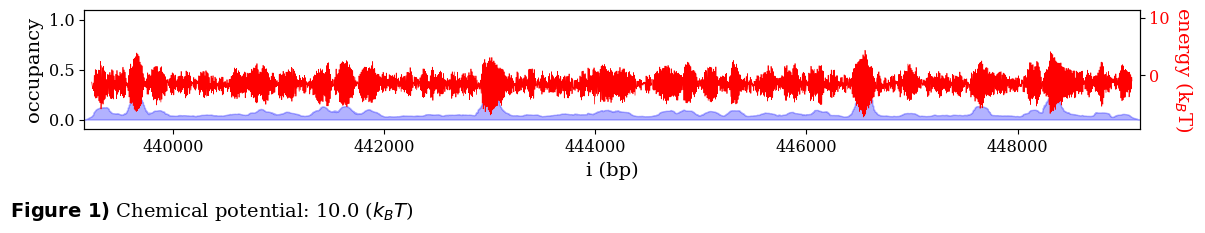

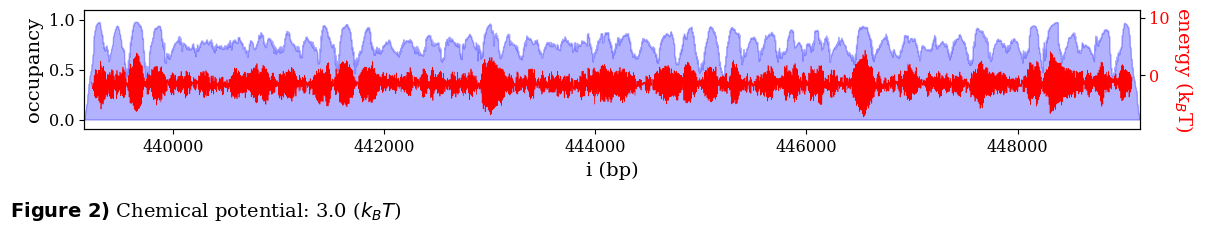

In [11]:
plotter = SequencePlotter()
for mu in np.linspace(10,3,2):
    fiber.calc_energy_landscape(amplitude=0.05, period=9.7, chemical_potential=mu)
    plotter.plot(fiber, energy=True)
    plotter.add_caption(f"Chemical potential: {mu} ($k_BT$)")
    plt.show()

Sampling fibers and calculating methylation: 100%|██████████| 50/50 [00:01<00:00, 32.22it/s]



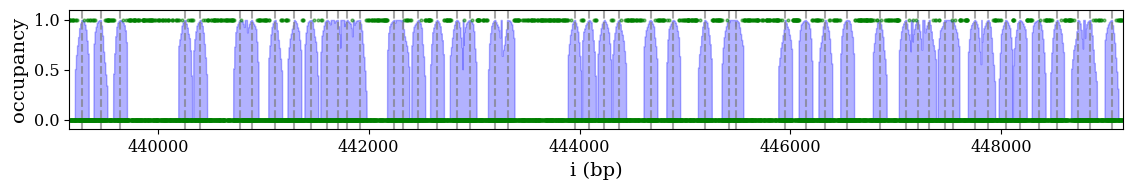

In [27]:
n = 50
methylated = []
for i in tqdm(range(n), desc="Sampling fibers and calculating methylation"):
    dyads, occupancy = fiber.sample_fiber_configuration()
    methylation = fiber.calc_methylation(dyads, efficiency=0.3, e_contact= -0.2)
    methylated.append(methylation.methylated)
plotter.plot(fiber, dyads=dyads, occupancy=methylation.protected, methylation=methylation.methylated)
plt.show()

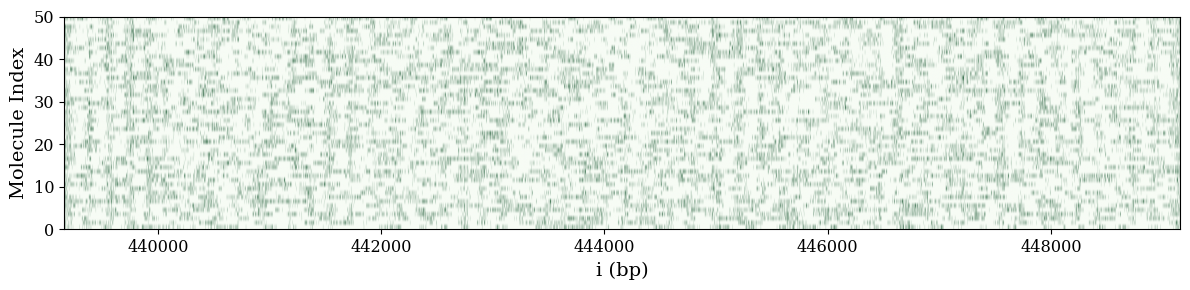

439157 439158


In [28]:
plt.figure(figsize=(12, 3))
plt.imshow(np.asarray(methylated)==1, aspect="auto", cmap="Greens", extent=(fiber.index[0].astype(float),fiber.index[-1].astype(float), 0, len(methylated)))
plt.xlabel("i (bp)")
plt.ylabel("Molecule Index")
plt.tight_layout()
plt.show()
print(fiber.index[0], fiber.index[1])

In [29]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

def create_cmap(crange = (0, 250)):
        
    colors = [(0, 'white'),
            (10, 'whitesmoke'),
            (30, 'magenta'),
            (45, 'blue'),
            (55, 'blue'),
            (90, 'cyan'),
            (100, 'cyan'),
            (132, 'lime'),
            (180, 'limegreen'),
            (250, 'darkgreen')]
    colors = [(x/colors[-1][0], c) for x, c in colors]

    # Define the new colors
    norm = mcolors.Normalize(vmin=crange[0], vmax=crange[1])
    cmap = mcolors.LinearSegmentedColormap.from_list(
        name='Sterachis',
        colors=colors,
        N=250  # Number of color steps
    )
    return cmap

cmap = create_cmap()


In [ ]:
def convert_methylations_to_df(methylations, minimal_footprint = 10):
    footprints = []
    for i, trace in enumerate(methylated):
        trace = np.asarray(trace).astype(bool)
        positions = np.asarray(fiber.index)[trace]
        # require at least two methylated positions to form an interval
        if positions.size < 2:
            continue
        starts = positions[:-1]
        ends = positions[1:]
        for s, e in zip(starts, ends):
            footprints.append((int(i), int(s), int(e), int(e - s)))
    # Create dataframe
    if footprints:
        df = pd.DataFrame.from_records(footprints, columns=["read_id", "start", "end", "width"]) 
    else:
        df = pd.DataFrame(columns=["read_id", "start", "end", "width"]) 

    return df[df["width"] > minimal_footprint]

df = convert_methylations_to_df(methylated,10)
ic(df)

ic| df:         read_id   start     end  width
        113| df:         read_id   start     end  width
        113           0  439381  439392     11
           0  439381  439392     11
        115           0  439393  439404     11
        224                   115           0  439393  439404     11
        224           0  439621  439633     12
        303           0  439812  439823     0  439621  439633     12
        303           0  439812  439823     11
        834           0  440958  440971     1311
        834           0  440958  440971     13
        ...         ...     ...     
        ...         ...     ...     ...    ...
        224610       49  443169  443182     13
        224637       49  443256  ...    ...
        224610       49  443169  443182     13
        224637       49  443256  443267     11
        224961       443267     11
        224961       49  443921  443935     14
        225014       49  444051  44406249  443921  443935     14
        225014       49

,read_id,start,end,width
113,0,439381,439392,11
115,0,439393,439404,11
224,0,439621,439633,12
303,0,439812,439823,11
834,0,440958,440971,13
...,...,...,...,...
224610,49,443169,443182,13
224637,49,443256,443267,11
224961,49,443921,443935,14
225014,49,444051,444062,11


0it [00:00, ?it/s]

50it [00:00, 90.30it/s]



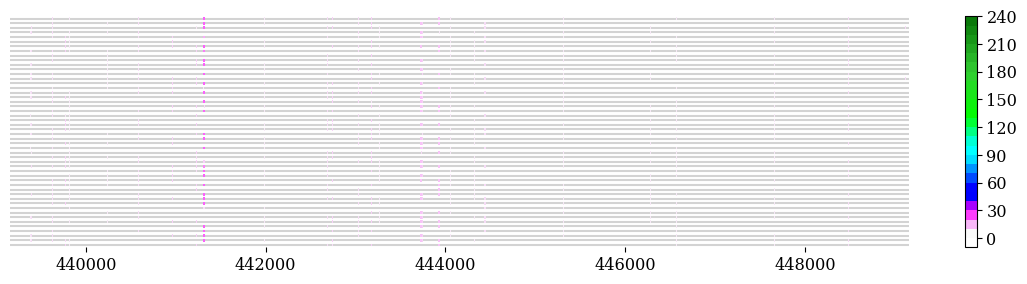

In [17]:
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def plot_domain_footprints(df, index):
    def plot_box(ax, xmin, xmax, ymin, ymax, color, alpha = 1):
        rectangle = mpatches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, facecolor=color, alpha=alpha)
        ax.add_patch(rectangle)
        ax.patch.set_zorder(2)

    ax= plt.gca()
      
    ids = df['read_id'].unique()
    xlim = (index[0], index[-1])

    plt.hlines(ids, color = 'lightgrey', *xlim, zorder = 1)
    norm = Normalize(0, 250)
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    crange = (-10, 250)
        
    for i, id in tqdm(enumerate(ids)):
        for _, row in df[df['read_id']==id].iterrows():
            plot_box(ax, row['start'], row['end'], i- 0.3, i+0.3, cmap(norm(np.clip(row['width'], *crange))))
    
    plt.xlim(xlim)
    plt.ylim( -0.5, i+0.5)
    
    plt.yticks([])
    plt.box(False)
    plt.gca().spines['left'].set_visible(False)

    plt.colorbar(sm, ax = ax, boundaries = np.arange(*crange, 10))
    plt.gcf().set_size_inches(14.5, 3)


    plt.show()
        
plot_domain_footprints(df, fiber.index)